In [1]:
%load_ext autoreload
%load_ext memory_profiler 
%load_ext dotenv
%autoreload 2
%dotenv

In [ ]:
from lightning import Trainer
from torchvision.transforms import v2 as T # type: ignore
from geovision.logging import get_logger
from geovision.config.basemodels import ExperimentConfig # noqa
from geovision.data.module import ImageDatasetDataModule
from geovision.io.local import get_ckpt_path, get_experiments_dir
from geovision.training.module import ClassificationModule
from geovision.training.loggers import (
    get_csv_logger, 
    # get_wandb_logger,
    get_ckpt_logger,
    # get_lr_logger,
    get_classification_logger
)
from geovision.analysis.plot_experiment import plot_experiment

In [ ]:
from torch import float32
from geovision.data.imagenette import Imagenette

logger = get_logger("experiment_logger")
transforms: dict[str, T.Transform | None] = {
    "image_transform": T.Compose([
        T.ToImage(), 
        T.Resize((224, 224), antialias=True), 
        T.ToDtype(float32, scale = True),
        T.Normalize(Imagenette.means, Imagenette.std_devs),
    ]),
    "target_transform": None,
    #"common_transform": None,
    "common_transform": T.RandomChoice([
        T.RandomHorizontalFlip(0.5),
        T.RandomVerticalFlip(0.5),
        T.RandomInvert(0.5),
        T.RandomAutocontrast(0.5)
    ]),
}
config = ExperimentConfig.from_yaml("config.yaml", transforms)
experiments_dir = get_experiments_dir(config)
datamodule = ImageDatasetDataModule(config)

loggers: list = list()
loggers.append(csv_logger := get_csv_logger(config))
# loggers.append(wandb_logger := get_wandb_logger(config))

callbacks: list = list()
callbacks.append(ckpt_logger := get_ckpt_logger(config))
callbacks.append(metrics_logger := get_classification_logger(config, log_every_n_steps=1, log_top_k=-1))
# callbacks.append(lr_logger := get_lr_logger(config))
# callbacks.append(LearningRateFinder(num_training_steps=147, early_stop_threshold=None))

In [ ]:
trainer = Trainer(
    max_epochs = 6,
    check_val_every_n_epoch = 2,
    num_sanity_val_steps = 0,
    log_every_n_steps = 1,
    #limit_train_batches = 20,
    #limit_val_batches = 0,

    logger = loggers,
    callbacks = callbacks,
    enable_checkpointing = True,
    enable_model_summary = False
)

litmodule = ClassificationModule(ExperimentConfig.from_yaml("config.yaml", transforms))
trainer.fit(
    model = litmodule,
    datamodule = datamodule,
    ckpt_path = get_ckpt_path(config)
)

Cleaner: val started at 295
Cleaner: val ended at 316
Cleaner: val started at 318
Cleaner: val ended at 319
Cleaner: val started at 615
Cleaner: val ended at 636
Cleaner: val started at 933
Cleaner: val ended at 954
Dropping idxs: [318, 319]


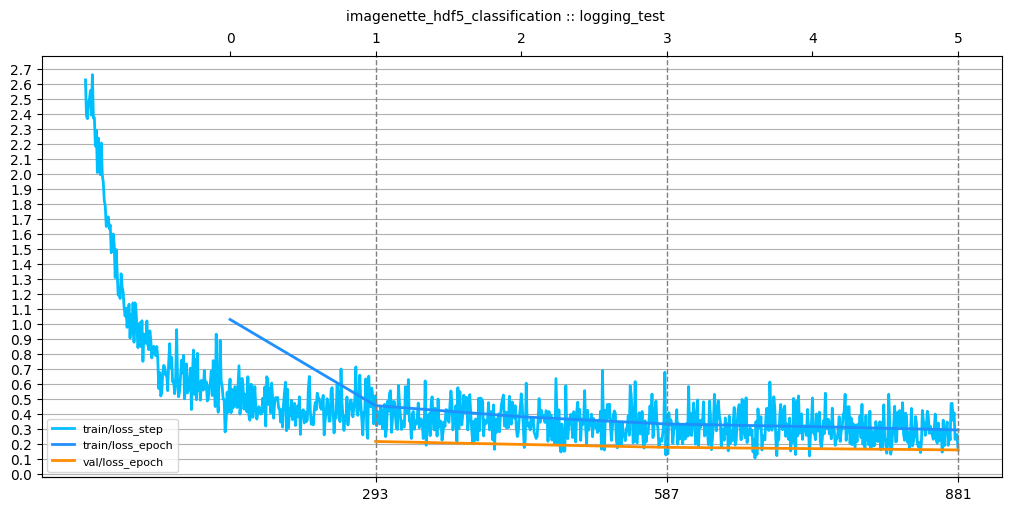

In [19]:
plot_experiment(config)

Cleaner: val started at 295
Cleaner: val ended at 316
Cleaner: val started at 318
Cleaner: val ended at 319
Cleaner: val started at 615
Cleaner: val ended at 636
Cleaner: val started at 933
Cleaner: val ended at 954
Dropping idxs: [318, 319]


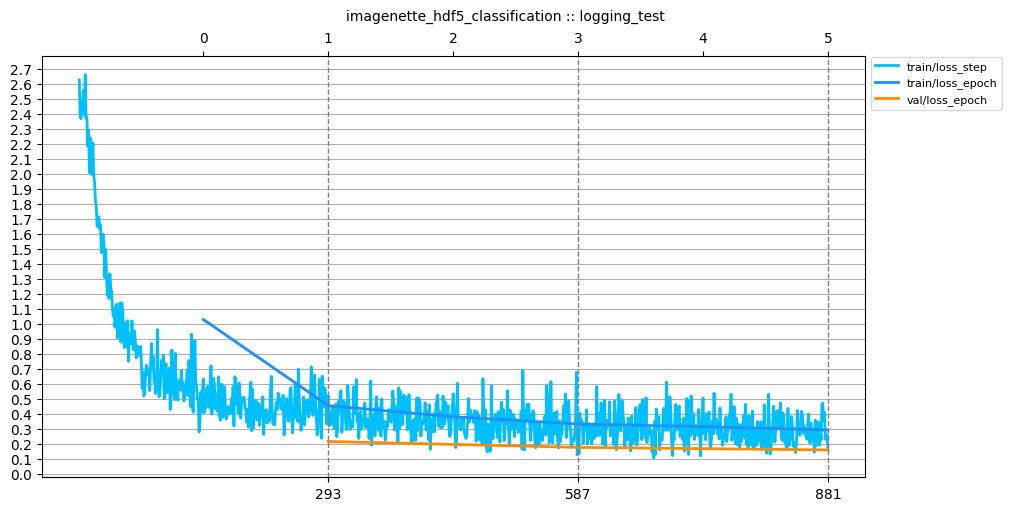

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geovision.analysis.plot_experiment import *  #noqa
from geovision.config.basemodels import ExperimentConfig

config = ExperimentConfig.from_yaml("config.yaml")
# pd.set_option("display.max_rows", None)
# metrics_df = get_metrics_df(config)  #noqa
# val_df = get_val_df(metrics_df, config.metric) #noqa
# display(val_df)